# Web scraping solution

## Step 1: Install dependencies

In [1]:
pip install pandas requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 45.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 95.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 83.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Step 2: Download HTML

In [5]:
import requests
import time

url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
html_data = requests.get(url, time.sleep(10)).text

# If no information is extracted, then connect as anonymous
if "403 Forbidden" in html_data:
    headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}
    request = requests.get(url, headers = headers)
    time.sleep(10)
    html_data = request.text

html_data

'<html>\r\n<head>\r\n\n</head>\r\n<body>\r\n<div style="margin: 50px auto; width: 50%; border: 1px solid #dfdfdf; padding: 20px 50px 30px 50px; font-family:helvetica;">\r\n\r\n<h1>We do not allow automated access to our servers.</h1>\r\n<h2><p>Automated access to our data is prohibited by our data provider.</p>  \r\n<p>If you are a user attempting to access the site via a browser, please follow this process to regain access:</p>\r\n\r\n<ul>\r\n  <li>Go to <a href=\'https://whatismyipaddress.com/\' target=\'_blank\' rel=\'noopener noreferrer\'>whatismyipaddress</a> and obtain your IPv4 address</li>\r\n  <li>Email us your IPv4 address at <a href="/cdn-cgi/l/email-protection" class="__cf_email__" data-cfemail="4821262e270825292b3a273c3a2d262c3b66262d3c">[email&#160;protected]</a></li>\r\n  <li>We will add you to our whitelist within 24 hours</li>\r\n</ul>\r\n</h2>\r\n</div>\r\n<script data-cfasync="false">!function(){"use strict";function e(e){try{if("undefined"==typeof console)return;"er

## Step 3: Transform the HTML

In [6]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(html_data,"html.parser")
soup

<html>
<head>
</head>
<body>
<div style="margin: 50px auto; width: 50%; border: 1px solid #dfdfdf; padding: 20px 50px 30px 50px; font-family:helvetica;">
<h1>We do not allow automated access to our servers.</h1>
<h2><p>Automated access to our data is prohibited by our data provider.</p>
<p>If you are a user attempting to access the site via a browser, please follow this process to regain access:</p>
<ul>
<li>Go to <a href="https://whatismyipaddress.com/" rel="noopener noreferrer" target="_blank">whatismyipaddress</a> and obtain your IPv4 address</li>
<li>Email us your IPv4 address at <a class="__cf_email__" data-cfemail="4821262e270825292b3a273c3a2d262c3b66262d3c" href="/cdn-cgi/l/email-protection">[email protected]</a></li>
<li>We will add you to our whitelist within 24 hours</li>
</ul>
</h2>
</div>
<script data-cfasync="false">!function(){"use strict";function e(e){try{if("undefined"==typeof console)return;"error"in console?console.error(e):console.log(e)}catch(e){}}function t(e,t){v

In [7]:
# Find all tables
tables = soup.find_all("table")
tables

[]

In [10]:
import pandas as pd

for index, table in enumerate(tables):
    if ("Tesla Quarterly Revenue" in str(table)):
        table_index = index
        break

# Create a DataFrame
tesla_revenue = pd.DataFrame(columns = ["Date", "Revenue"])
for row in tables[table_index].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        Date = col[0].text
        Revenue = col[1].text.replace("$", "").replace(",", "")
        tesla_revenue = pd.concat([tesla_revenue, pd.DataFrame({
            "Date": Date,
            "Revenue": Revenue
        }, index = [0])], ignore_index = True)

tesla_revenue.head()

NameError: name 'table_index' is not defined

## Step 4: Process the DataFrame

In [9]:
tesla_revenue = tesla_revenue[tesla_revenue["Revenue"] != ""]
tesla_revenue.head()

,Date,Revenue


## Step 5: Store the data in sqlite

In [11]:
import sqlite3

connection = sqlite3.connect("Tesla.db")
connection

In [12]:
cursor = connection.cursor()
cursor.execute("""CREATE TABLE revenue (Date, Revenue)""")

In [13]:
tesla_tuples = list(tesla_revenue.to_records(index = False))
tesla_tuples[:5]

[]

In [14]:
cursor.executemany("INSERT INTO revenue VALUES (?,?)", tesla_tuples)
connection.commit()

In [15]:
# Check the data from the database
for row in cursor.execute("SELECT * FROM revenue"):
    print(row)

## Step 6: Visualize the data

### Time serie visualization

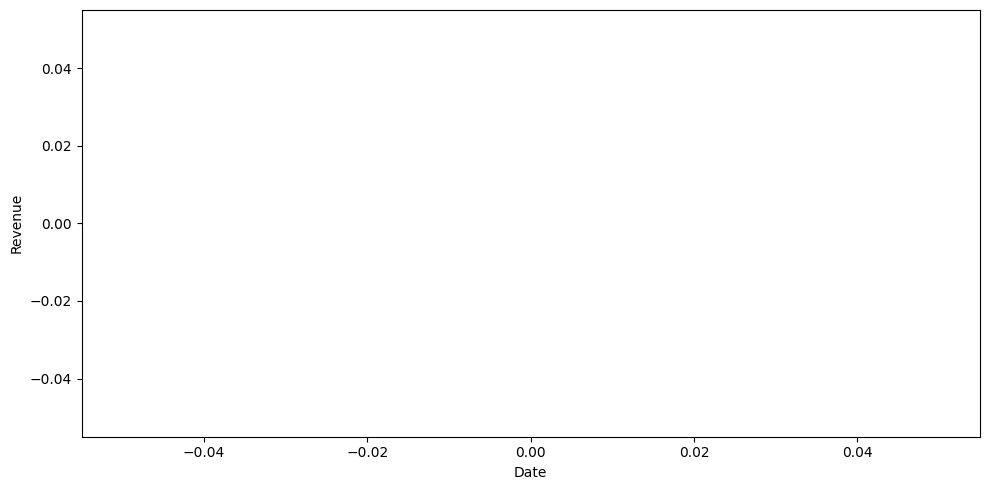

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].astype('int')
sns.lineplot(data = tesla_revenue, x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()

### Anual gross benefit

TypeError: datetime64 type does not support sum operations

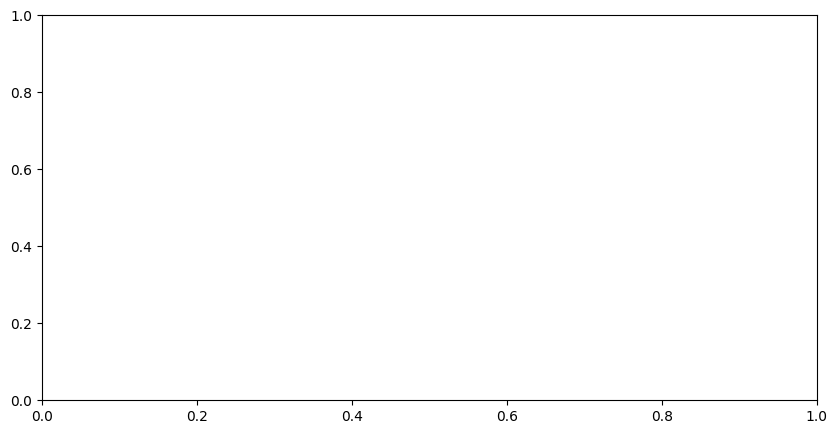

In [17]:
fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
tesla_revenue_yearly = tesla_revenue.groupby(tesla_revenue["Date"].dt.year).sum().reset_index()

sns.barplot(data = tesla_revenue_yearly[tesla_revenue_yearly["Date"] < 2023], x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()

### Monthly gross benefit

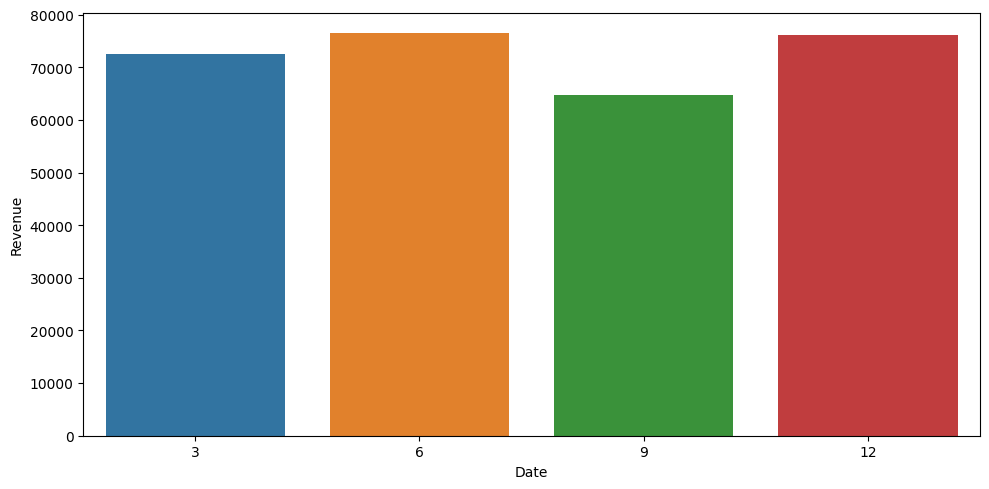

In [14]:
fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue_monthly = tesla_revenue.groupby(tesla_revenue["Date"].dt.month).sum().reset_index()

sns.barplot(data = tesla_revenue_monthly, x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()